In [1]:
from time import time

class Timer(object):
  def __init__(self, verbose=False):
    self.verbose = verbose  

  def __enter__(self):
    self.start = time()
    return self

  def __exit__(self, *args):
    self.end = time()
    self.secs = self.end - self.start
    self.msecs = self.secs * 1000  # millisecs
    if self.verbose:
      print 'elapsed time: %f ms' % self.msecs

In [2]:
from os import listdir
from os.path import isfile, join
docLabels = []
docLabels = [f for f in listdir("data/instagram_activities/") if '.csv' in f]

print 'documents:', len(docLabels)
print docLabels

documents: 11
['instagram_activities.csv.0', 'instagram_activities.csv.1', 'instagram_activities.csv.10', 'instagram_activities.csv.2', 'instagram_activities.csv.3', 'instagram_activities.csv.4', 'instagram_activities.csv.5', 'instagram_activities.csv.6', 'instagram_activities.csv.7', 'instagram_activities.csv.8', 'instagram_activities.csv.9']


In [5]:
import csv

data = []
for doc in docLabels:
    print 'Parsing ', doc
    with open('data/instagram_activities/' + doc, 'rb') as csvfile:
        csvReader = csv.reader(csvfile, delimiter=',', quotechar='"')
        for row in csvReader:
            data.append([row[0], [str(s) for s in eval(row[1])]])

print len(data)

Parsing  instagram_activities.csv.0
Parsing  instagram_activities.csv.1
Parsing  instagram_activities.csv.10
Parsing  instagram_activities.csv.2
Parsing  instagram_activities.csv.3
Parsing  instagram_activities.csv.4
Parsing  instagram_activities.csv.5
Parsing  instagram_activities.csv.6
Parsing  instagram_activities.csv.7
Parsing  instagram_activities.csv.8
Parsing  instagram_activities.csv.9
1005459


In [6]:
import gensim

sentences = [gensim.models.doc2vec.LabeledSentence(words=doc[0].split(),tags=doc[1]) for doc in data]

In [ ]:
sentences[0]

In [ ]:
model = gensim.models.Doc2Vec(size=300, window=10, min_count=15, workers=11, alpha=0.025, min_alpha=0.025) # use fixed learning rate
model.build_vocab(sentences)

for epoch in range(10):
    with Timer() as t:
        model.train(sentences)
        model.alpha -= 0.002 # decrease the learning rate
        model.min_alpha = model.alpha # fix the learning rate, no deca
        model.train(sentences)
    print "Trainning time for epoch", epoch, "is", t.secs2

In [7]:
# model.save('1M_10epochs')

import gensim

model = gensim.models.Doc2Vec.load('1M_10epochs')

In [6]:
model.most_similar("#fashion")

[('#styleblogger', 0.46287840604782104),
 ('#chic', 0.44484537839889526),
 ('#styling', 0.43868303298950195),
 ('#musthave', 0.42052674293518066),
 ('#stylist', 0.3903328776359558),
 ('#fashiondiaries', 0.38955020904541016),
 ('#instastyle', 0.3828691244125366),
 ('#luxury', 0.3825111389160156),
 ('#vogue', 0.3796754479408264),
 ('#classy', 0.37371736764907837)]

In [7]:
model.most_similar("#traveloregon")

[('#pacificnorthwest', 0.6167587041854858),
 ('#oregonnw', 0.5623527765274048),
 ('#upperleftusa', 0.5443731546401978),
 ('#exploregon', 0.5350562334060669),
 ('#getoutdoors', 0.5323786735534668),
 ('#exploreoregon', 0.5168024301528931),
 ('#virginiaisforlovers', 0.5144643783569336),
 ('#adventure', 0.5078577995300293),
 ('#pnwonderland', 0.49604180455207825),
 ('#bestoforegon', 0.48957616090774536)]

In [8]:
model.doesnt_match('#fashion #design #store'.split())

'#store'

In [8]:
import pandas as pd

ratings = pd.read_csv('data/instagram_ratings.csv', header=None)
ratings['docvecs']     = ratings[0].apply(lambda x: model.docvecs[str(x)])
ratings['docvecs_len'] = ratings['docvecs'].apply(lambda x: len(x))

ratings = ratings[ratings['docvecs_len'] == 300]
ratings = ratings.reset_index(drop=True)

ratings.head()

0      1  \
0  443640355416351476  False   
1  443640355416243447  False   
2  443640355416196263  False   
3  443640355416149938  False   
4  443640355416140376  False   

                                                   2                     3  \
0  Top off your killer look with our vintage insp...  content_not_relevant   
1  A stunning piece for the true global vagabond,...  content_not_relevant   
2    Moon daisy mornings üåô wonderlandclothing.com ‚ú®  content_not_relevant   
3  Tie dye and butterflies from @gioglitter in ou...  content_not_relevant   
4  Opium Harness available now on my shop , Fully...  content_not_relevant   

      4                                            docvecs  docvecs_len  
0  5982  [-0.142505, 0.0481642, -0.0550694, 0.0606493, ...          300  
1  5982  [-0.0439086, -0.00913453, 0.0909323, -0.052497...          300  
2  5982  [-0.00118915, -0.03137, -0.00607291, 0.0493308...          300  
3  5982  [0.0247944, -0.109643, -0.0197312, -0.047658, ...          300  
4  5982  [0.0298661, -0.0467364, -0.0342047, -0.0701144...          300

In [ ]:
import numpy as np
from sklearn.manifold import TSNE

X = np.array(ratings[0])
X = [model.docvecs[str(x)] for x in X]

tsne = TSNE(n_components=3, random_state=0)
np.set_printoptions(suppress=True)

representation = tsne.fit_transform(X)

In [141]:
print ratings[1].loc[ratings[1] == True].index

Int64Index([   6,    9,   10,   11,   12,   13,   14,   15,   16,   17,
            ...
            3132, 3134, 3136, 3137, 3138, 3139, 3141, 3142, 3143, 3151],
           dtype='int64', length=1589)


In [158]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline 

# plot the result
vis_x = representation[:, 0]
vis_y = representation[:, 1]
vis_z = representation[:, 2]

print 'representation:', len(representation)
print 'ratings:', len(ratings)

representation: 3152
ratings: 3152


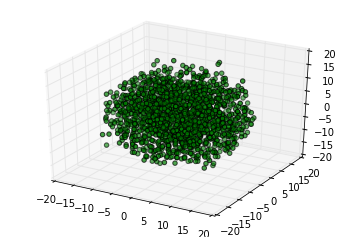

In [154]:
fig = plt.figure()

true_idxs = ratings[1].loc[ratings[1] == True].index
ax = fig.add_subplot(111, projection='3d')
ax.scatter(vis_x[true_idxs], vis_y[true_idxs], vis_z[true_idxs], c='g')

plt.show()

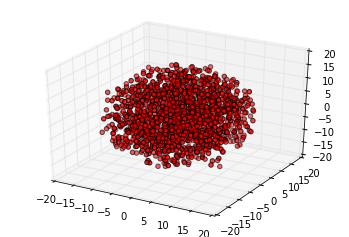

In [155]:
fig = plt.figure()

false_idxs = ratings[1].loc[ratings[1] == False].index
ax = fig.add_subplot(111, projection='3d')
ax.scatter(vis_x[false_idxs], vis_y[false_idxs], vis_z[false_idxs], c='r')

plt.show()

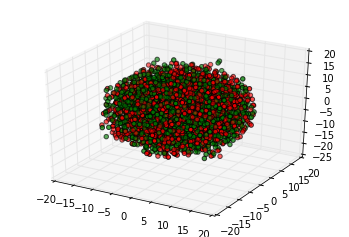

In [156]:
fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')
ax.scatter(vis_x, vis_y, vis_z, c=[('b' if x == True else 'r') for x in ratings[1]])

plt.show()

In [9]:
def makeFeatureVec(vecs, model, num_features):
    # Function to average all of the doc vectors in a given
    # type of feedback
    #
    # Pre-initialize an empty numpy array (for speed)
    featureVec = np.zeros((num_features,),dtype="float32")
        #
    # Loop over each word in the review and, if it is in the model's
    # vocaublary, add its feature vector to the total
    for vec in vecs:
        featureVec = np.add(featureVec, vec)
    # 
    # Divide the result by the number of words to get the average
    featureVec = np.divide(featureVec,len(vecs))
    return featureVec

In [10]:
good_vec = makeFeatureVec(ratings.loc[ratings[1] == True]['docvecs'], model, 300)
bad_vec = makeFeatureVec(ratings.loc[ratings[1] == False]['docvecs'], model, 300)

NameError: global name 'np' is not defined

In [ ]:
from numpy import dot

ratings['cosine_good'] = ratings[0].apply(lambda _id: dot(model.docvecs[str(_id)], good_vec))
ratings['cosine_bad'] = ratings[0].apply(lambda _id: dot(model.docvecs[str(_id)], bad_vec))
ratings['cosine_rule'] = ratings.apply(lambda row: dot(model.docvecs['rule_' + str(row[4])], model.docvecs[row[1]]), axis=1)
ratings['cosine_rule_good'] = ratings[4].apply(lambda rule: dot(model.docvecs['rule_' + str(rule)], good_vec))
ratings['cosine_rule_bad'] = ratings[4].apply(lambda rule: dot(model.docvecs['rule_' + str(rule)], bad_vec))

fig = plt.figure()

plt.scatter(ratings['cosine_good'], ratings['cosine_bad'], c=[('g' if good else 'r') for good in ratings[1]])

plt.show()

In [276]:
import sklearn

result = ratings[ratings[1] == (ratings['cosine_good'] >= ratings['cosine_bad'])]

print sklearn.metrics.confusion_matrix(ratings[1], ratings['cosine_model'])
print 'score:', len(result)/float(len(ratings))

ValueError: Can't handle mix of binary and unknown

In [273]:
from sklearn import svm
from sklearn.cross_validation import KFold
from sklearn.metrics import confusion_matrix
from time import ctime

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier

k_fold = KFold(n=len(X), n_folds=2, shuffle=True)
b_scores, svc_scores = [], []

#x_data = np.array(X)
x_data = np.array(ratings[['cosine_good', 'cosine_bad', 'cosine_rule', 'cosine_rule_good', 'cosine_rule_bad']].values)
y_data = np.array([(1 if x else 0) for x in ratings[1]])

for tr_indices, cv_indices in k_fold:
    tr    = x_data[tr_indices]
    cv    = x_data[cv_indices]

    tr_y  = y_data[tr_indices]
    cv_y  = y_data[cv_indices]

    clf = KNeighborsClassifier()
    
    print '- Starting:', ctime()
    clf.fit(tr, tr_y)
    print(confusion_matrix(cv_y, clf.predict(cv)))    
    print('#### SCORE:' + str(clf.score(cv, cv_y)))

- Starting: Mon Jan 18 17:46:23 2016
[[791  13]
 [ 23 749]]
#### SCORE:0.977157360406
- Starting: Mon Jan 18 17:46:23 2016
[[750   9]
 [ 25 792]]
#### SCORE:0.978426395939


In [290]:
clf = KNeighborsClassifier()
clf.fit(x_data, y_data)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [291]:
newest = pd.read_csv('data/instagram_last_activities.csv', header=None)
newest.head()

0                                                  1  \
0  443640355414011195  Double tap the image to see the message! Then,...   
1  443640355414209709  I do! I do! How cute is this wooden greeting s...   
2  443640355415209472  Hello elegance! Keep everything chic with thes...   
3  443640355415353762  We're talking all things #weddings + staying a...   
4  443640355415519184  Connections, comfort, convenience! Click the l...   

                                     2     3  
0  https://instagram.com/p/3HDH9bhBvD/  3603  
1  https://instagram.com/p/3HekKchBrt/  3603  
2  https://instagram.com/p/3Jn9BOhBvg/  3603  
3  https://instagram.com/p/3J5gyNBBvu/  3603  
4  https://instagram.com/p/3KNbr7hBlE/  3603

In [301]:
_newest = newest.head(50)

_newest['cosine_good'] = _newest[1].apply(lambda body: dot(model.infer_vector(body.split()), good_vec))
_newest['cosine_bad'] = _newest[1].apply(lambda body: dot(model.infer_vector(body.split()), bad_vec))
_newest['cosine_rule'] = _newest.apply(lambda row: dot(model.docvecs['rule_' + str(row[3])], model.infer_vector(row[1].split())), axis=1)
_newest['cosine_rule_good'] = _newest[3].apply(lambda rule: dot(model.docvecs['rule_' + str(rule)], good_vec))
_newest['cosine_rule_bad'] = _newest[3].apply(lambda rule: dot(model.docvecs['rule_' + str(rule)], bad_vec))

/Users/felipeclopes/Projects/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/felipeclopes/Projects/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/felipeclopes/Projects/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

In [302]:
_newest.head(50)

0                                                  1  \
0   443640355414011195  Double tap the image to see the message! Then,...   
1   443640355414209709  I do! I do! How cute is this wooden greeting s...   
2   443640355415209472  Hello elegance! Keep everything chic with thes...   
3   443640355415353762  We're talking all things #weddings + staying a...   
4   443640355415519184  Connections, comfort, convenience! Click the l...   
5   443640355415519184  Connections, comfort, convenience! Click the l...   
6   443640355573003555  Be careful where you selfie or Intel might put...   
7   443640355573027751  Everyone's a photobomber with Ricoh's Theta S ...   
8   443640355573435448  These toy dinosaurs are powered by IBM Watson ...   
9   443640355573988375  Looks like we've found another @TaylorSwift fa...   
10  443640355574138773  This is what our future generation looks like ...   
11  443640355544195248  These orange babies are ready for some shuffle...   
12  443640355544196048  Bicycle in HamsterJam - colour match your scar...   
13  443640355572746012        #tnweurope #tnwconference #amsterdam #Bridg   
14  443640355572746013        #tnweurope #tnwconference #amsterdam #Bridg   
15  443640355572746078        #tnweurope #tnwconference #amsterdam #Bridg   
16  443640355380151527  Beautiful day #wildernessculturee #wanderlust ...   
17  443640355380151529  Breathtaking sights from the lakefront in Glen...   
18  443640355380152137                                                üèÇ.   
19  443640355380152139  s u r f a c e\nHere's a teaser from my next ex...   
20  443640355380152160                        City Market ... Kansas City   
21  443640355579312060  Cascading 286 feet, Salt Creek Falls is Oregon...   
22  443640355579312060  Cascading 286 feet, Salt Creek Falls is Oregon...   
23  443640355579391934  "Where we're going, we don't need roads..." Wh...   
24  443640355579391934  "Where we're going, we don't need roads..." Wh...   
25  443640355579508957  Today was spent hustling. To the coffee shop, ...   
26  443640355579508957  Today was spent hustling. To the coffee shop, ...   
27  443640355579787526  Starting today with the Special at The Ridge C...   
28  443640355579787526  Starting today with the Special at The Ridge C...   
29  443640355579820133  We walked into Willamette Mountain Mercantile ...   
30  443640355579820133  We walked into Willamette Mountain Mercantile ...   
31  443640355575064486  "Nature always wears the colors of the spirit....   
32  443640355576966972  Behind every twist and turn, there's always so...   
33  443640355577439937  Something magic happened here at #thepeoplesco...   
34  443640355577827586  A peek through forested gates reveals one of t...   
35  443640355578588893  May your weekend be filled with lightness and ...   
36  443640355579820144  took a walk to new seasons with my people. yes...   
37  443640355579820145  Waiting for #Spring. .\n.\n.\n.\n.\n.\n.\n.\n....   
38  443640355579820146  // MISTY MORNING // @zachdilday @brandynmorley...   
39  443640355579820164  Happy MLK day! Hope you get outside and get to...   
40  443640355579820165  All that is gold does not glitter,\nNot all th...   
41  443640355577423092  –ù–æ–≤–∞—è —É–ª—É—á—à–µ–Ω–Ω–∞—è –≤–µ—Ä—Å–∏—è –∂—É—Ä–Ω–∞–ª–∞ BigMag —É–∂–µ –Ω–∞ ...   
42  443640355577456153  #regram from @digest.digital: " - I had a lot ...   
43  443640355577555352  Pretty cool to see my @wolf_millionaire articl...   
44  443640355577567445  Checkout my @wolf_millionaire article publishe...   
45  443640355577928265  Pretty cool to see my first major article üìù f...   
46  443640355544195210                                 #TNWUSA afterparty   
47  443640355544195237                                 #TNWUSA afterparty   
48  443640355544195252                                  Oo la la! #TNWUSA   
49  443640355544195334                      #tnwusa networking like a pro   

                                           2     3  cosi

In [306]:
_newest_data = np.array(_newest[['cosine_good', 'cosine_bad', 'cosine_rule', 'cosine_rule_good', 'cosine_rule_bad']].values)

_newest['predicted'] = clf.predict(_newest_data)

/Users/felipeclopes/Projects/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [307]:
_newest.head(50)

0                                                  1  \
0   443640355414011195  Double tap the image to see the message! Then,...   
1   443640355414209709  I do! I do! How cute is this wooden greeting s...   
2   443640355415209472  Hello elegance! Keep everything chic with thes...   
3   443640355415353762  We're talking all things #weddings + staying a...   
4   443640355415519184  Connections, comfort, convenience! Click the l...   
5   443640355415519184  Connections, comfort, convenience! Click the l...   
6   443640355573003555  Be careful where you selfie or Intel might put...   
7   443640355573027751  Everyone's a photobomber with Ricoh's Theta S ...   
8   443640355573435448  These toy dinosaurs are powered by IBM Watson ...   
9   443640355573988375  Looks like we've found another @TaylorSwift fa...   
10  443640355574138773  This is what our future generation looks like ...   
11  443640355544195248  These orange babies are ready for some shuffle...   
12  443640355544196048  Bicycle in HamsterJam - colour match your scar...   
13  443640355572746012        #tnweurope #tnwconference #amsterdam #Bridg   
14  443640355572746013        #tnweurope #tnwconference #amsterdam #Bridg   
15  443640355572746078        #tnweurope #tnwconference #amsterdam #Bridg   
16  443640355380151527  Beautiful day #wildernessculturee #wanderlust ...   
17  443640355380151529  Breathtaking sights from the lakefront in Glen...   
18  443640355380152137                                                üèÇ.   
19  443640355380152139  s u r f a c e\nHere's a teaser from my next ex...   
20  443640355380152160                        City Market ... Kansas City   
21  443640355579312060  Cascading 286 feet, Salt Creek Falls is Oregon...   
22  443640355579312060  Cascading 286 feet, Salt Creek Falls is Oregon...   
23  443640355579391934  "Where we're going, we don't need roads..." Wh...   
24  443640355579391934  "Where we're going, we don't need roads..." Wh...   
25  443640355579508957  Today was spent hustling. To the coffee shop, ...   
26  443640355579508957  Today was spent hustling. To the coffee shop, ...   
27  443640355579787526  Starting today with the Special at The Ridge C...   
28  443640355579787526  Starting today with the Special at The Ridge C...   
29  443640355579820133  We walked into Willamette Mountain Mercantile ...   
30  443640355579820133  We walked into Willamette Mountain Mercantile ...   
31  443640355575064486  "Nature always wears the colors of the spirit....   
32  443640355576966972  Behind every twist and turn, there's always so...   
33  443640355577439937  Something magic happened here at #thepeoplesco...   
34  443640355577827586  A peek through forested gates reveals one of t...   
35  443640355578588893  May your weekend be filled with lightness and ...   
36  443640355579820144  took a walk to new seasons with my people. yes...   
37  443640355579820145  Waiting for #Spring. .\n.\n.\n.\n.\n.\n.\n.\n....   
38  443640355579820146  // MISTY MORNING // @zachdilday @brandynmorley...   
39  443640355579820164  Happy MLK day! Hope you get outside and get to...   
40  443640355579820165  All that is gold does not glitter,\nNot all th...   
41  443640355577423092  –ù–æ–≤–∞—è —É–ª—É—á—à–µ–Ω–Ω–∞—è –≤–µ—Ä—Å–∏—è –∂—É—Ä–Ω–∞–ª–∞ BigMag —É–∂–µ –Ω–∞ ...   
42  443640355577456153  #regram from @digest.digital: " - I had a lot ...   
43  443640355577555352  Pretty cool to see my @wolf_millionaire articl...   
44  443640355577567445  Checkout my @wolf_millionaire article publishe...   
45  443640355577928265  Pretty cool to see my first major article üìù f...   
46  443640355544195210                                 #TNWUSA afterparty   
47  443640355544195237                                 #TNWUSA afterparty   
48  443640355544195252                                  Oo la la! #TNWUSA   
49  443640355544195334                      #tnwusa networking like a pro   

                                           2     3  cosi

In [29]:
ratings['hashtags'] = ratings[2].apply(lambda x: filter(lambda x: x.startswith('#'), x.replace(',', ' ').split(' ')))

In [32]:
def doesnt_match(hashtags):
    print hashtags
    r = 0
    if len(hashtags) > 2:
        r = len(model.doesnt_match(hashtags))
    print r
    return r

ratings['doesnt_match'] = ratings['hashtags'].apply(lambda h: doesnt_match(h))

[]
0
['#trinkithunter', '#fortheoriginalgypsy', '#saltwaterwanderer', '#gypsyjewels', '#belt', '#afghani', '#tribal', '#vintage', '#artisan', '#handcrafted', '#saltwatergypsy', '#gypsy', '#gypset', '#gypsystyle', '#gypsyfashion', '#gypsygoddess', '#boho', '#bohemian', '#bohostyle', '#bohofashion', '#bohogoddess', '#beachbabe', '#festivalstyle', '#festivalfashion', '#byronbay', '#sitg15', '#splendour15']
8
[]
0
['#fashion', '#style', '#regram', '#tiedye', '#SS15', '#festivalfashion', '#tattoos', '#butterflies', '#fringing', '#fblogger', '#fbloggers', '#glamorous', '#ukglamorous']
7
['#bohochic', '#bohogirl', '#bohostyle', '#bohofashion', '#badstarlingerie', '#fashion', '#festivalstyle', '#festivalfashion', '#gypsychic', '#gypsystyle', '#hippie', '#handmade', '#hippiechic', '#hippiestyle', '#ibizastyle', '#polefitness']
12
['#grunge', '#grungestyle', '#altfashion', '#festival', '#festivalfashion', '#festivalstyle', '#blogger', '#fashionblogger', '#instablogger', '#grungeblog', '#bohogrun

ValueError: cannot select a word from an empty list